In [1]:
from functools import partial
from numba import jit
from scipy.spatial import KDTree
from scipy.spatial.distance import cdist

from astropy.coordinates import cartesian_to_spherical, spherical_to_cartesian

import craterdetection.common.constants as const
from craterdetection.common.camera import Camera
from craterdetection.common.coordinates import ENU_system
from craterdetection.matching.database import extract_robbins_dataset, load_craters, CraterDatabase
from craterdetection.matching.position_estimation import derive_position
from craterdetection.matching.projective_invariants import crater_representation, CoplanarInvariants
from craterdetection.common.conics import *
from craterdetection.matching.utils import shift_nd
import astropy.units as u

In [2]:
lat_cat, long_cat, major_cat, minor_cat, psi_cat, crater_id = extract_robbins_dataset(
    load_craters("../data/lunar_crater_database_robbins_2018.csv", diamlims=[2, 30], ellipse_limit=1.4)
)
r_craters_cat = np.array(np.array(spherical_to_cartesian(const.RMOON, lat_cat, long_cat))).T[..., None]
C_craters_cat = crater_representation(major_cat, minor_cat, psi_cat)

In [25]:
resolution = (256, 256)

# Camera parameters can be derived from RNG
cam_lat, cam_long = map(np.radians, (45., 45.))
cam_alt = 120

cam = Camera.from_coordinates(cam_lat, cam_long, cam_alt, resolution=resolution)

# cam.T = (Rotation.from_matrix(cam.T) * Rotation.from_euler('x', 0, degrees=True)).as_matrix()

dist = cam_alt / np.cos(np.radians(cam.fov/2)*np.sqrt(2) * 1.0)
vicinity = (np.sqrt(np.sum(np.square(r_craters_cat - cam.r), axis=1)) < dist).ravel()
r_craters = r_craters_cat[vicinity]
C_craters = C_craters_cat[vicinity]
A_craters = cam.project_crater_conics(C_craters, r_craters)

crater_centers = cam.project_crater_centers(r_craters)

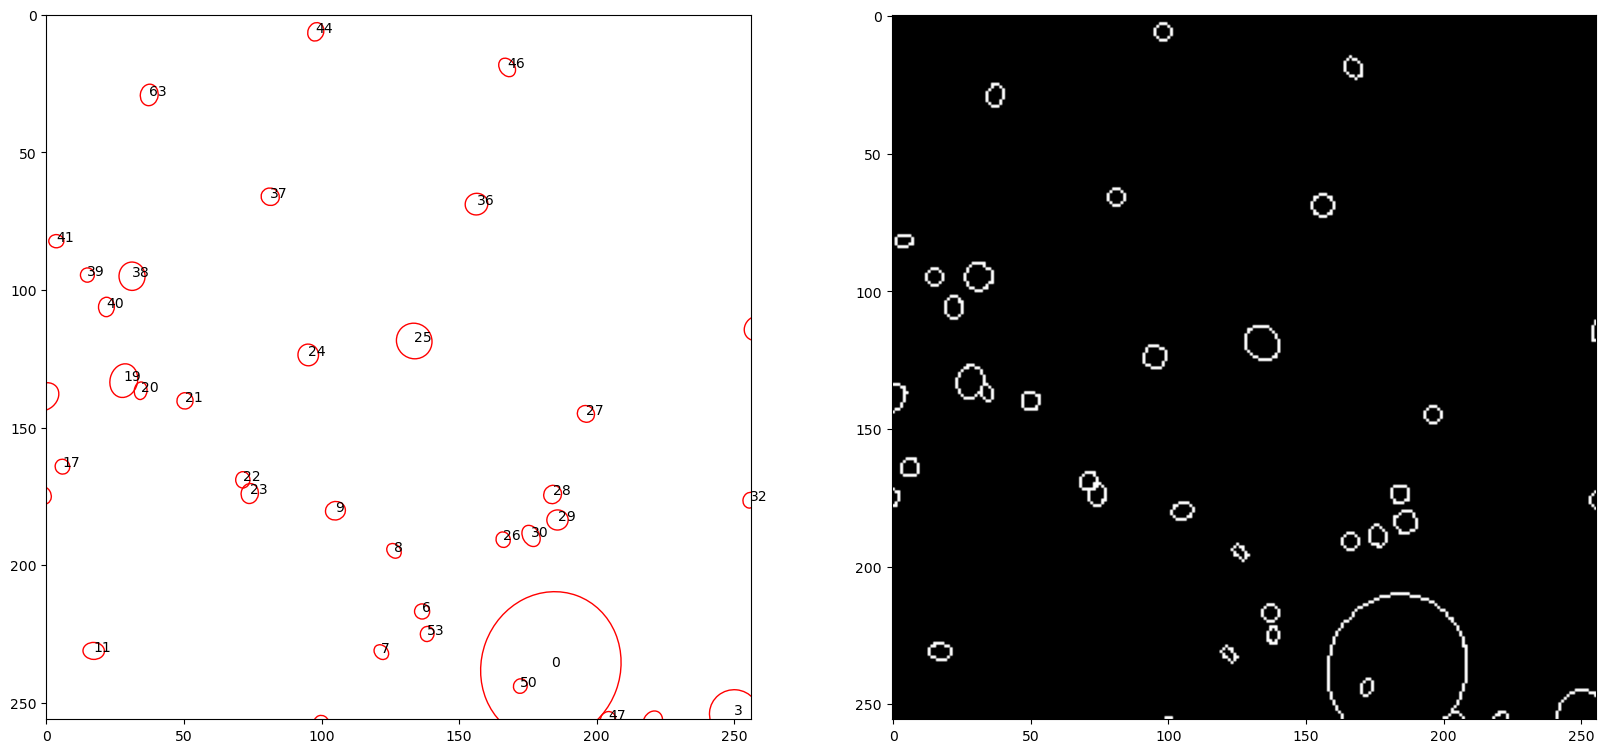

In [26]:
plt.style.use('default')

fig, axes = plt.subplots(1, 2, figsize=(20, 40), subplot_kw={'aspect': 'equal'})

plot_conics(A_craters, resolution=cam.resolution, plot_centers=True, ax=axes[0])
detection_order = np.argsort(cdist(crater_centers, np.array(cam.resolution)[None, :]/2).squeeze())

# plot_conics(A_craters[detection_order], resolution=cam.resolution, plot_centers=True, ax=axes[1])

img_ellipses = generate_mask(A_craters, resolution=resolution, instancing=False)

axes[1].imshow(img_ellipses, cmap='Greys_r')
fig.savefig('output/crater_mask_example.pdf', bbox_inches = 'tight', pad_inches = 0)

In [27]:
# db = CraterDatabase.from_file("../data/lunar_crater_database_robbins_2018.csv", diamlims=[3, 30], latlims=[20, 70], longlims=[20, 70], radius=100, ellipse_limit=1.4)
db = CraterDatabase(lat_cat[vicinity], long_cat[vicinity], major_cat[vicinity], minor_cat[vicinity], psi_cat[vicinity], radius=500)

In [28]:
sigma_pix = 1

n_det = len(A_craters)
# Add noise
major_det, minor_det = ellipse_axes(A_craters)
psi_det = ellipse_angle(A_craters)
r_craters_det = conic_center(A_craters)

major_det += np.random.uniform(-sigma_pix, sigma_pix, size=n_det)
minor_det += np.random.uniform(-sigma_pix, sigma_pix, size=n_det)
psi_det += np.random.normal(scale=(10/180)*np.pi, size=n_det)
r_craters_det += np.random.normal(-sigma_pix, sigma_pix, size=r_craters_det.shape)

A_craters_noisy = crater_representation(major_det, minor_det, psi_det, *r_craters_det.T)

In [29]:
def distance_metric(A_i: np.ndarray, A_j: np.ndarray):
    Y_i = -A_i[:, :2, :2]
    Y_j = -A_j[:, :2, :2]

    y_i = np.expand_dims(conic_center(A_i), axis=-1)
    y_j = np.expand_dims(conic_center(A_j), axis=-1)

    d = np.arccos(
        (4*np.sqrt(LA.det(Y_i)*LA.det(Y_j)) / (LA.det(Y_i + Y_j))) \
        * np.exp(-0.5 * (y_i - y_j).transpose(0,2,1) @ Y_i @ LA.inv(Y_i + Y_j) @ Y_j @ (y_i - y_j)).flatten()
    )

    return d.flatten()

def hypothesis_match(A_i, A_j, sigma_img, threshold=13.276):
    d_GA = distance_metric(A_i, A_j)

    a_i, b_i = ellipse_axes(A_i)

    sigma = (0.85 / np.sqrt(a_i * b_i)) * sigma_img

    return (d_GA ** 2) / (sigma ** 2) < threshold

In [65]:
%%time
batch_size = 10000
top_n = 3

max_matches = 60

assert max_matches % 3 == 0, "Matches are appended in sets of 3!"

top_n = [top_n] if top_n == 1 else top_n

A_matched = np.full((max_matches, 3, 3), -1, np.float64)
C_matched = np.full((max_matches, 3, 3), -1, np.float64)
r_matched =  np.full((max_matches, 3, 1), -1, np.float64)

est_r = np.empty((max_matches//3, 3, 1), np.float64)

crater_triads, features = next(CoplanarInvariants.match_generator(A_craters=A_craters_noisy, max_iter=10, batch_size=batch_size))
dummy_position = np.zeros_like(cam.r, np.float64)
match_projector = Camera(dummy_position, cam.T, cam.fov, cam.resolution)
min_n = db.query(features, k=top_n)

i = 0
for candidates, triad in zip(min_n, crater_triads):
    r_craters_match, C_craters_match = db[candidates]
    for r, C in zip(r_craters_match, C_craters_match):
        match_projector.r = derive_position(A_craters_noisy[triad], r, C, cam.T, cam.K())
        alt = LA.norm(match_projector.r)
        if not const.RMOON < alt < const.RMOON + 500:
            break
        A_craters_projected = match_projector.project_crater_conics(C, r)

        A_i = scale_det(A_craters_projected)
        A_j = scale_det(A_craters_noisy[triad])
        h = hypothesis_match(A_i, A_j, sigma_pix)
        if all(h):
            print('MATCH')
            print(f"\tPosition error: {(LA.norm(cam.r.ravel() - match_projector.r.ravel()) * u.km).to(u.m):.2f}")
            A_matched[i:i+3, ...] = A_i
            C_matched[i:i+3, ...] = C
            r_matched[i:i+3, ...] = r

            cum_r = derive_position(A_matched[:i+3], r_matched[:i+3], C_matched[:i+3], cam.T, cam.K())
            print(f"\tCumulative position error: {(LA.norm(cam.r.ravel() - cum_r.ravel()) * u.km).to(u.m):.2f}")
            est_r[i//3] = cum_r

            i += 3
            break

    if i >= max_matches:
        break

MATCH
	Position error: 2338.09 m
	Cumulative position error: 2338.09 m
MATCH
	Position error: 1473.42 m
	Cumulative position error: 868.52 m
MATCH
	Position error: 1362.22 m
	Cumulative position error: 524.57 m
MATCH
	Position error: 2825.85 m
	Cumulative position error: 525.08 m
MATCH
	Position error: 568.41 m
	Cumulative position error: 517.48 m
MATCH
	Position error: 1015.95 m
	Cumulative position error: 588.01 m
MATCH
	Position error: 547.04 m
	Cumulative position error: 555.71 m
MATCH
	Position error: 3793.39 m
	Cumulative position error: 511.41 m
MATCH
	Position error: 2908.34 m
	Cumulative position error: 502.30 m
MATCH
	Position error: 945.79 m
	Cumulative position error: 516.89 m
MATCH
	Position error: 1488.85 m
	Cumulative position error: 508.97 m
MATCH
	Position error: 3263.02 m
	Cumulative position error: 521.15 m
MATCH
	Position error: 1246.70 m
	Cumulative position error: 510.06 m
MATCH
	Position error: 1067.08 m
	Cumulative position error: 531.11 m
MATCH
	Position error:

In [53]:
r_craters_match, C_craters_match = map(partial(np.moveaxis, source=1, destination=0), db[min_n])

A_craters_match = A_craters_noisy[crater_triads]

In [54]:
@njit
def pos_lsq_broadcast(A, b):
    out = np.empty((A.shape[0], 3, 1))

    for ii in range(A.shape[0]):
        Q, R = LA.qr(A[ii])
        Qb = np.dot(Q.T, b[ii])
        out[ii] = LA.solve(R, Qb)
    return out

In [55]:
k = np.array([0., 0., 1.])[:, None]
S = np.concatenate((np.identity(2), np.zeros((1, 2))), axis=0)

In [67]:
%%time
B_craters = cam.T @ cam.K().T @ A_craters_match @ cam.K() @ LA.inv(cam.T)

r = r_craters_match[0]
C = C_craters_match[0]

T_EM = np.concatenate(ENU_system(r), axis=-1)
T_ME = LA.inv(T_EM)

A = (S.T @ T_ME @ B_craters).reshape(-1, 6, 3)

b = (S.T @ T_ME @ B_craters @ r).reshape(-1, 6, 1)

match_est_pos = pos_lsq_broadcast(A, b)

Wall time: 33 ms


In [57]:
H_Mi = np.concatenate((np.concatenate(ENU_system(r), axis=-1) @ S, r), axis=-1)

P_MC = cam.K() @ LA.inv(cam.T) @ np.concatenate((np.tile(np.identity(3), (len(match_est_pos), 1, 1)), -match_est_pos), axis=2)
#
H_C = P_MC[:, None, ...] @ np.concatenate((H_Mi, np.tile(k.T[None, ...], (len(H_Mi), 3, 1, 1))), axis=-2)

In [58]:
A_projected = LA.inv(H_C.transpose(0, 1, 3, 2)) @ C @ LA.inv(H_C)

Y_i = -A_projected[..., :2, :2]
Y_j = -A_craters_match[..., :2, :2]

y_i = np.expand_dims(conic_center(A_projected), axis=-1)
y_j = np.expand_dims(conic_center(A_craters_match), axis=-1)

d = np.arccos(
    (4*np.sqrt(LA.det(Y_i)*LA.det(Y_j)) / (LA.det(Y_i + Y_j))) \
    * np.exp(-0.5 * (y_i - y_j).transpose(0,1,3,2) @ Y_i @ LA.inv(Y_i + Y_j) @ Y_j @ (y_i - y_j)).squeeze()
)
d

C:\Users\w_dop\miniconda3\envs\crater-detection\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.
C:\Users\w_dop\miniconda3\envs\crater-detection\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


array([[1.57071596, 1.57071846, 1.5707176 ],
       [1.57064918, 1.57069658, 1.57068788],
       [1.57072467, 1.57071995, 1.57072133],
       ...,
       [1.57071482, 1.57071291, 1.57072281],
       [1.57072776, 1.57071839, 1.570721  ],
       [1.57071188, 1.57070916, 1.57071581]])

In [59]:
a_i, b_i = ellipse_axes(A_projected)

sigma = (0.85 / np.sqrt(a_i * b_i)) * sigma_pix
sigma

C:\dev\workspace\crater-detection\craterdetection\common\conics.py:119: RuntimeWarning: invalid value encountered in sqrt
  axes = np.sqrt(1 / lambdas)


array([[0.0164566 , 0.12277725, 0.14619237],
       [0.03839059, 0.04691516, 0.04419434],
       [0.19963692, 0.21848114, 0.21326828],
       ...,
       [0.14087714, 0.13973862, 0.15449019],
       [0.03770983, 0.04708155, 0.04891233],
       [0.16810348, 0.12893585, 0.13959646]])

In [64]:
match = np.where(((d / sigma) ** 2) < 13.276)

if len(match[0]) > 0:
    print(derive_position(A_craters_match[match].reshape(-1, 3, 3),
                          r[match].reshape(-1, 3, 1),
                          C[match].reshape(-1, 3, 3),
                          cam.T,
                          cam.K()))

In [ ]:
import matplotlib.ticker as ticker

plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(LA.norm(cam.r - est_r, axis=(1)).flatten()*1000, '-rx')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0fm'))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))

plt.xlabel("Number of crater triad matches")
plt.ylabel("Position error")

# MC Simulation

In [ ]:
latlims = (45, 60)
longlims = (45, 60)
diamlims = (2, 30)
ellipse_limit = 1.2
arclims = 0.5

triad_radius = 100

lat_cat, long_cat, major_cat, minor_cat, psi_cat, crater_id = extract_robbins_dataset(
    load_craters(
        "../data/lunar_crater_database_robbins_2018.csv",
        latlims=latlims,
        longlims=longlims,
        diamlims=diamlims,
        ellipse_limit=ellipse_limit,
        arc_lims=arclims
    )
)
db = CraterDatabase(lat_cat, long_cat, major_cat, minor_cat, psi_cat, radius=triad_radius)

r_craters_cat = np.array(np.array(spherical_to_cartesian(const.RMOON, lat_cat, long_cat))).T[..., None]
C_craters_cat = crater_representation(major_cat, minor_cat, psi_cat)

In [ ]:
test_size = 1
resolution = (256, 256)

position_dataset = np.empty((test_size, 3, 1), np.float64)
attitude_dataset = np.empty((test_size, 3, 3), np.float64)

est_position_dataset = np.empty((test_size, 3, 1), np.float64)

position_noise = 2 #pixels
axis_noise = 1 #pixels
angle_noise = np.radians(20)

max_iter = 1
match_threshold = 0.01

for i in range(test_size):

    lat = np.random.uniform(*latlims)
    long = np.random.uniform(*longlims)
    cam_alt = np.random.uniform(150, 250)
    cam = Camera.from_coordinates(lat,
                                  long,
                                  cam_alt,
                                  convert_to_radians=True,
                                  resolution=resolution
                                  )

    # save cam.r, sol_incidence
    position_dataset[i] = cam.r

    # Rotations are incremental (order matters)
    cam.rotate('roll', np.random.uniform(0, 360))
    cam.rotate('pitch', np.random.uniform(-30, 30))
    cam.rotate('yaw', np.random.uniform(-30, 30))

    # save cam.T
    attitude_dataset[i] = cam.T

    visible = (cdist(r_craters_cat.squeeze(), cam.r.T) <= np.sqrt(2 * cam_alt * const.RMOON + cam_alt**2)).ravel()
    r_craters = r_craters_cat[visible]
    C_craters = C_craters_cat[visible]

    r_craters_img = cam.project_crater_centers(r_craters)
    in_image = np.logical_and.reduce(np.logical_and(r_craters_img > -20, r_craters_img < cam.resolution[0]+20), axis=1)

    r_craters = r_craters[in_image]
    C_craters = C_craters[in_image]

    A_craters = cam.project_crater_conics(C_craters, r_craters)
    n_det = len(A_craters)

    major_det, minor_det = ellipse_axes(A_craters)
    psi_det = ellipse_angle(A_craters)
    r_craters_det = conic_center(A_craters)

    major_det += np.random.uniform(-axis_noise, axis_noise, n_det)
    minor_det += np.random.uniform(-axis_noise, axis_noise, n_det)
    psi_det += np.random.uniform(-angle_noise, angle_noise, n_det)
    r_craters_det += np.random.uniform(-position_noise, position_noise, r_craters_det.shape)

    A_craters_noisy = crater_representation(major_det, minor_det, psi_det, *r_craters_det.T)
    if n_det >= 3:
        A_craters_det, r_craters_det, C_craters_det = db.match_detections(
                                                                  A_craters_noisy,
                                                                  max_iter=max_iter,
                                                                  threshold=match_threshold
                                                              )
        if len(A_craters_det) > 1:
            est_position_dataset[i] = derive_position(
                A_craters_det,
                r_craters_det,
                C_craters_det,
                cam.T,
                cam.K()
            )
        else:
            est_position_dataset[i] = np.ones((3,1))*-1
    else:
        est_position_dataset[i, ...] = -1

In [ ]:
matched_positions = (est_position_dataset[:,0,:] != -1).ravel()
est_position_dataset[matched_positions] - position_dataset[matched_positions]